In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, jit, vmap

In [2]:
import dmeq

In [3]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import arviz as az

In [4]:
n_chains = 10
numpyro.set_host_device_count(n_chains)

In [5]:
seed = random.PRNGKey(42)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
import pickle
from dataclasses import dataclass
from typing import Any, Sequence
from jaxtyping import PyTree, Float, Array
from flax import linen as nn
from jax.nn import sigmoid

@dataclass
class Surrogate():
    model: Any
    params: PyTree
    param_keys: Sequence[str]
    param_stats: Sequence[Float[Array, 'input_dim']]
    output_ranges: Sequence[Sequence[int]]
    output_stats: Sequence[Sequence[Float[Array, 'output_dim']]]
    
    def run(self, p):
        input_array = jnp.array([p[k] for k in self.param_keys])
        standardised_input = (input_array - self.param_stats[0]) / self.param_stats[1]
        output = self.model.apply(self.params, standardised_input)
        standardised_result = jnp.concatenate([
            output[self.output_ranges[i][0]:self.output_ranges[i][1]] *
                self.output_stats[i][1] + self.output_stats[i][0]
            for i in range(len(self.output_ranges))
        ])
        reshaped = jnp.reshape(
            standardised_result,
            (
                len(self.output_ranges),
                (self.output_ranges[0][1] - self.output_ranges[0][0])
            )
        )
        delta = 1e-10
        return jnp.minimum(jnp.maximum(reshaped, delta), 1. - delta)

class MLP(nn.Module):
    units: int
    n_hidden: int
    n_output: int

    def setup(self):
        self.layers = [nn.Dense(self.units) for _ in range(self.n_hidden)]
        self.output_layer = nn.Dense(self.n_output)

    def __call__(self, inputs):
        x = inputs
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            x = nn.relu(x)
        return self.output_layer(x)

with open('eq_surrogate', 'rb') as f:
    surrogate = pickle.load(f)

In [80]:
def prev_stats(params, eir, eta, impl):
    p = dmeq.default_parameters()
    (
        p['kb'],
        p['ub'],
        p['b0'],
        p['IB0'],
        p['kc'],
        p['uc'],
        p['IC0'],
        p['phi0'],
        p['phi1'],
        p['PM'],
        p['dm'],
        # p['kd'],
        # p['ud'],
        # p['d1'],
        # p['ID0'],
        # p['fd0'],
        # p['gd'],
        # p['ad0'],
        # p['rU'],
        # p['cD'],
        # p['cU'],
        # p['g_inf']
    )= params
    p['EIR'] = eir
    p['eta'] = eta
    solution = impl(p)
    return jnp.array([
        solution[0, 3:10].sum() / solution[2, 3:10].sum(), # Prev 2 - 10
        solution[0, 10:].sum() / solution[2, 10:].sum(), # Prev 10+
        solution[1, :5].sum() / solution[2, :5].sum(), # Inc 0 - 5
        solution[1, 5:15].sum() / solution[2, 5:15].sum(), # Inc 5 - 15
        solution[1, 15:].sum() / solution[2, 15:].sum() # Inc 15+
    ])

In [50]:
def prev_stats_multisite(params, eirs, etas, impl):
    return jnp.ravel(vmap(prev_stats, in_axes=[None, 0, 0, None])(params, eirs, etas, impl))

In [51]:
population = 100_000
EIRs = jnp.array([0.05, 3.9, 15., 20., 100., 150., 418.])
etas = 1. / (random.normal(seed, shape=EIRs.shape, dtype=jnp.float64) * 2 * 365 + 20*365)

In [81]:
def model(prev=None, impl=dmeq.solve):
    # Pre-erythrocytic immunity
    kb = numpyro.sample('kb', dist.TruncatedDistribution(dist.Normal(2., 1.), low=.1, high=10.))
    ub = numpyro.sample('ub', dist.TruncatedDistribution(dist.Normal(5., 1.), low=1., high=10.))
    b0 = numpyro.sample('b0', dist.Beta(1., 1.))
    IB0 = numpyro.sample('IB0', dist.LeftTruncatedDistribution(dist.Normal(50., 10.), low=1.))
    
    # Clinical immunity
    kc = numpyro.sample('kc', dist.Gamma(2., 1.))
    uc = numpyro.sample('uc', dist.Gamma(5., 1.))
    phi0 = numpyro.sample('phi0', dist.Beta(5., 1.))
    phi1 = numpyro.sample('phi1', dist.Beta(1., 2.))
    IC0 = numpyro.sample('IC0', dist.LeftTruncatedDistribution(dist.Normal(100., 10.), low=1.))
    PM = numpyro.sample('PM', dist.Beta(1., 1.))
    dm = numpyro.sample('dm', dist.LeftTruncatedDistribution(dist.Normal(200., 10.), low=0.))
    
#     # Detection immunity
#     kd = numpyro.sample('kd', dist.Gamma(2., 1))
#     ud = numpyro.sample('ud', dist.Gamma(5., 1.))
#     d1 = numpyro.sample('d1', dist.Beta(1., 2.))
#     ID0 = numpyro.sample('ID0', dist.LeftTruncatedDistribution(dist.Normal(25., 1.), low=1.))
#     fd0 = numpyro.sample('fd0', dist.Beta(1., 1.))
#     gd = numpyro.sample('gd', dist.Gamma(1., 1.))
#     ad0 = numpyro.sample(
#         'ad0',
#         dist.TruncatedDistribution(dist.Normal(30. * 365., 1.), low=20. * 365., high=40.*365)
#     )
    
#     du = numpyro.sample('du', dist.LeftTruncatedDistribution(dist.Normal(50., 1.), low=0.))
    
#     # FOIM
#     cd = numpyro.sample('cd', dist.Beta(1., 2.))
#     cu = numpyro.sample('cu', dist.Beta(1., 5.))
#     g_inf = numpyro.sample('g_inf', dist.Gamma(3., 1.))
    
    pred_prev = prev_stats_multisite([
        kb,
        ub,
        b0,
        IB0,
        kc,
        uc,
        IC0,
        phi0,
        phi1,
        PM,
        dm,
        # kd,
        # ud,
        # d1,
        # ID0,
        # fd0,
        # gd,
        # ad0,
        # 1. / du,
        # cd,
        # cu,
        # g_inf
    ], EIRs, etas, impl)
    
    numpyro.sample(
        'obs',
        dist.Independent(
            dist.Binomial(total_count=population, probs=pred_prev),
            1
        ),
        obs=prev
    )

In [82]:
true_values = Predictive(model, num_samples=1)(seed)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [83]:
true_values

{'IB0': Array([55.93777163], dtype=float64),
 'IC0': Array([94.55753044], dtype=float64),
 'PM': Array([0.61014955], dtype=float64),
 'b0': Array([0.35407383], dtype=float64),
 'dm': Array([201.62779889], dtype=float64),
 'kb': Array([3.71957704], dtype=float64),
 'kc': Array([1.54355741], dtype=float64),
 'obs': Array([[  373,   476,     1,     6,     8, 16440, 11985,   115,   174,
           171, 34408, 22839,   331,   529,   503, 38973, 23666,   418,
           632,   514, 64722, 33785,  1383,  1589,  1280, 69989, 36498,
          1700,  2001,  1617, 81107, 46081,  3136,  3545,  3138]],      dtype=int64),
 'phi0': Array([0.88068824], dtype=float64),
 'phi1': Array([0.20328874], dtype=float64),
 'ub': Array([5.09317686], dtype=float64),
 'uc': Array([7.92831917], dtype=float64)}

In [84]:
observations = true_values['obs'][0]

In [85]:
observations

Array([  373,   476,     1,     6,     8, 16440, 11985,   115,   174,
         171, 34408, 22839,   331,   529,   503, 38973, 23666,   418,
         632,   514, 64722, 33785,  1383,  1589,  1280, 69989, 36498,
        1700,  2001,  1617, 81107, 46081,  3136,  3545,  3138],      dtype=int64)

In [86]:
from numpyro.contrib.tfp.mcmc import RandomWalkMetropolis
import tensorflow_probability as tfp

In [87]:
n_samples = 1000
n_warmup = 5000

kernel = RandomWalkMetropolis(
    model,
    new_state_fn=tfp.substrates.jax.mcmc.random_walk_normal_fn(scale=.04)
)

mcmc = MCMC(
    kernel,
    num_samples=n_samples,
    num_warmup=n_warmup,
    num_chains=n_chains,
)
mcmc.run(seed, observations, dmeq.solve)
mcmc.print_summary(prob=0.7)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     56.96      6.67     57.03     48.97     63.17      6.27      2.63
       IC0    112.72      8.53    112.66    101.87    119.64     11.98      1.72
        PM      0.48      0.25      0.52      0.09      0.56      5.04     15.40
        b0      0.36      0.01      0.36      0.35      0.36      6.89      2.24
        dm     68.13     89.49      1.52      0.08    178.51      5.26      9.85
        kb      3.19      1.36      2.81      2.01      3.12      5.23      7.67
        kc      1.04      0.26      0.92      0.73      1.24      5.43      4.81
      phi0      0.90      0.04      0.90      0.86      0.94      5.36      7.02
      phi1      0.16      0.05      0.16      0.07      0.19      5.32      5.75
        ub      4.97      1.80      4.29      3.28      6.73      5.24      9.19
        uc      2.29      1.61      2.06      0.39      3.11      5.18      8.57



In [88]:
prior = Predictive(model, num_samples=600)(seed)

In [89]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(seed, observations, dmeq.solve)

In [90]:
pyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)

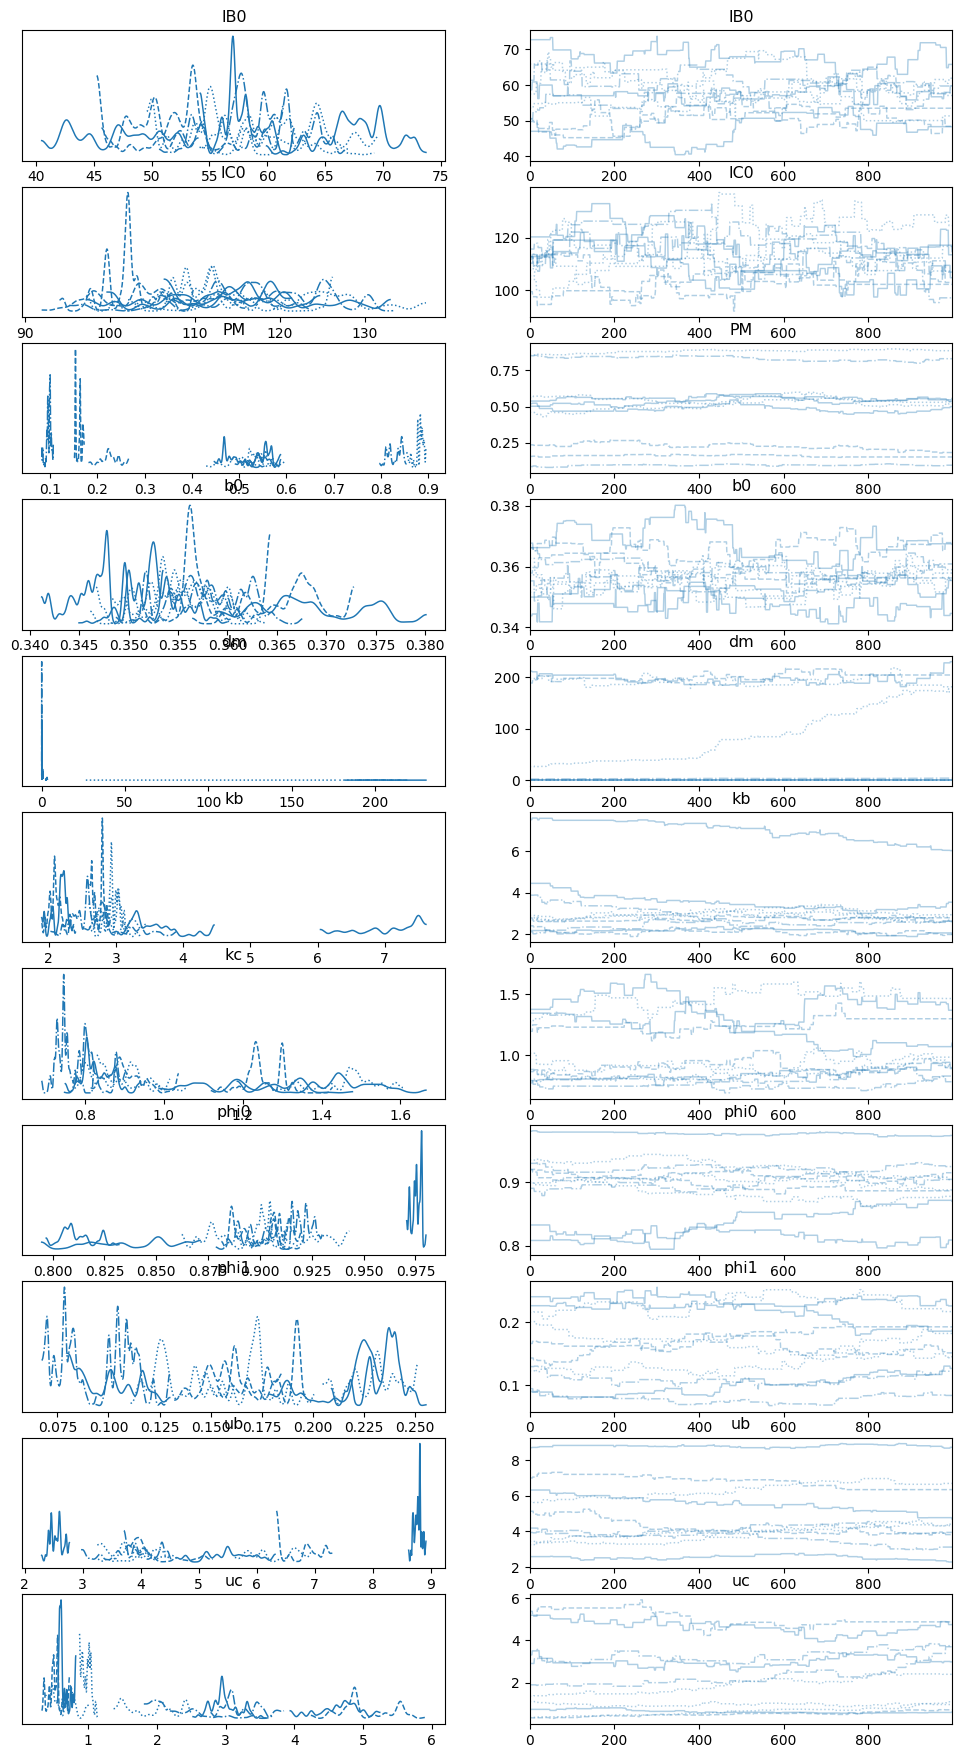

In [91]:
az.rcParams["plot.max_subplots"] = 200
axs = az.plot_trace(pyro_data)

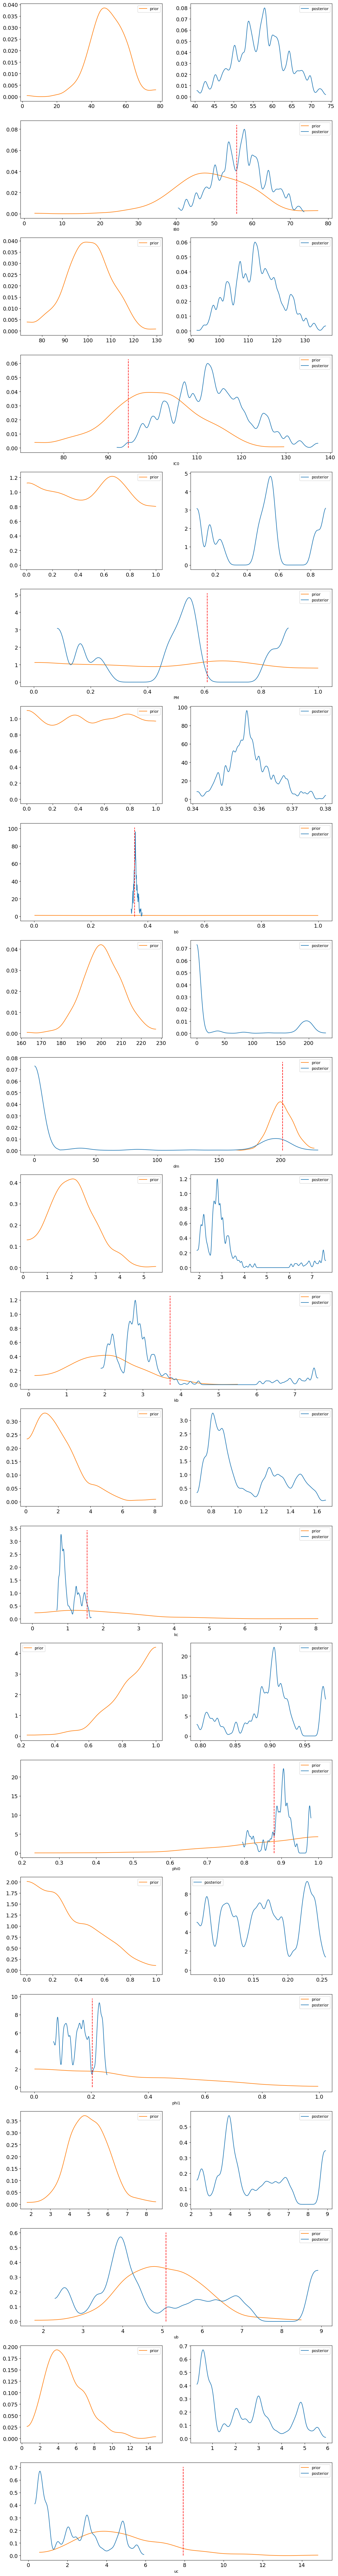

In [92]:
keys = list(pyro_data.prior.data_vars.keys())
axs = az.plot_dist_comparison(pyro_data)
for i in range(axs.shape[0]):
    axs[i, 2].vlines(
        true_values[keys[i]][0],
        0,
        axs[i, 2].get_ylim()[1],
        color = 'red',
        linestyle = 'dashed'
    )